expected csv file column names:

Max_Topology </br>
Length </br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
FILE_IN_NAME = "clustered_v2.csv.gz"
FILE_OUT_NAME = "length_normalized_v2.csv.gz"

BIN_SIZE = 5

In [3]:
df_in = pd.read_csv(FILE_IN_NAME)
print(df_in.head())

                 ID  latestVersion  globalMetricValue  uniprotStart  \
0  AF-A0A2I1RDW2-F1              4              74.81             1   
1      AF-R7J1F5-F1              4              81.44             1   
2  AF-A0A850ZUB3-F1              4              71.38             1   
3  AF-A0A496S0D7-F1              4              87.75             1   
4  AF-A0A4S5J7W7-F1              4              81.94             1   

   uniprotEnd                                    uniprotSequence  Length  \
0         658  MTPYGEPPAPAGPPAEVRYPFSAVVGQEQLKLALILSAISPGIGGV...   658.0   
1         330  MQFAHPHLLWLIPIVLALLIARYVYTARNARPTMGVSTTAPFANMP...   330.0   
2         140  LDAELQLDRLKPKLSRRVLLLQGHQSSWHEGLVLAPATPPLCHNLT...   140.0   
3         338  MKKTSAVKWTKKHLLGIEELSAEEILLILDQAVGFKEVLERPIPKV...   338.0   
4         524  MIADFHFLRPWWLFALLAAPLLVRLIGRRTDIRSRWEGMIAPHLLN...   524.0   

  Domain_architecture InterPro Max_Topology  Max Freq Knot Core  
0                 NaN      NaN          NaN       

In [4]:
df_pos = df_in[df_in['Max_Topology'].notnull()]
df_neg = df_in[df_in['Max_Topology'].isnull()]

### Preprocess dataset

In [5]:
df_pos = df_pos.assign(label=1)
df_neg = df_neg.assign(label=0)

Sequence length is considered in bins of size BIN_SIZE (currently 5)

In [6]:
df_pos = df_pos.assign(bin_len = df_pos['Length'].apply(lambda x: x - x % BIN_SIZE))
df_neg = df_neg.assign(bin_len = df_neg['Length'].apply(lambda x: x - x % BIN_SIZE))

df_pos = df_pos.sort_values(by=['bin_len'])
df_neg = df_neg.sort_values(by=['bin_len'])

df_pos = df_pos.reset_index(drop=True)
df_neg = df_neg.reset_index(drop=True)

### Make new dataset with similar positive and negative sequence length distribution

In [7]:
pos = 0
neg = 0

df = pd.DataFrame(columns=df_pos.columns)

pbar = tqdm(total = len(df_pos))

while pos < len(df_pos) and neg < len(df_neg):
    if df_pos['bin_len'][pos] == df_neg['bin_len'][neg]:
        df = pd.concat([df, df_pos.iloc[[pos]]], ignore_index=True)
        df = pd.concat([df, df_neg.iloc[[neg]]], ignore_index=True)
        pos += 1
        neg += 1
        pbar.update(1)
    elif df_pos['bin_len'][pos] > df_neg['bin_len'][neg]:
        neg += 1
    else:
        pos += 1
        pbar.update(1)
        
pbar.close()

print(df)

100%|██████████| 200477/200477 [18:25<00:00, 181.36it/s] 

                      ID latestVersion  globalMetricValue uniprotStart  \
0       AF-A0A530NMD7-F1             4              93.94            1   
1       AF-A0A2K3KRM4-F1             4              92.69            1   
2       AF-A0A7Y2E992-F1             4              91.44            1   
3       AF-A0A0D7ARU9-F1             4              80.12            1   
4       AF-A0A2D9EXY8-F1             4              82.12            1   
...                  ...           ...                ...          ...   
198781  AF-A0A668VD23-F1             4              76.88            1   
198782  AF-A0A847LGM4-F1             4              79.69            1   
198783  AF-A0A7L9BQV1-F1             4              80.75            1   
198784      AF-W2KIX8-F1             4              74.31            1   
198785  AF-A0A2K5ZBM5-F1             4              84.56            1   

       uniprotEnd                                    uniprotSequence  Length  \
0              73  LVLLTIKAAAAY

In [8]:
df = df.drop(columns='bin_len')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv(FILE_OUT_NAME, index=False)

In [9]:
print(f"Positives: {len(df[df['label'] == 1])}")
print(f"Negatives: {len(df[df['label'] == 0])}")

Positives: 99393
Negatives: 99393


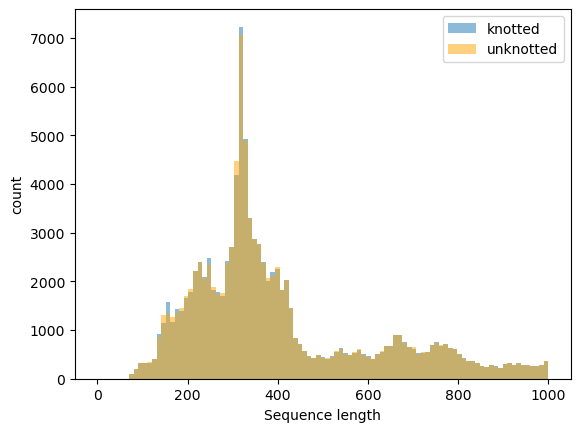

In [10]:
plt.hist(df[df['label'] == 1]['Length'].tolist(), bins=np.linspace(0, 1000, 100), alpha=0.5, label='knotted')

plt.hist(df[df['label'] == 0]['Length'].tolist(), bins=np.linspace(0, 1000, 100), alpha=0.5, color='orange', label='unknotted')

plt.legend()
plt.xlabel('Sequence length')
plt.ylabel('count')

plt.show()